In [1]:
pip install lightgbm


In [3]:
# src/train_model.py

import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load features
df = pd.read_csv("data/wallet_features.csv")

# Labeling logic: repay/borrow ≥ 0.8 → Good (1), else Bad (0)
df['label'] = (df['repay_borrow_ratio'] >= 0.8).astype(int)

# Select features
features = ['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']
X = df[features]
y = df['label']

# Apply log transform to reduce skew
X = np.log1p(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LightGBM classifier
model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(model, "data/credit_model.pkl")


[LightGBM] [Info] Number of positive: 569, number of negative: 1878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 2447, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232530 -> initscore=-1.194082
[LightGBM] [Info] Start training from score -1.194082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

['data/credit_model.pkl']

In [9]:
# scoring.py

import pandas as pd
import numpy as np
import joblib

# Load model and features
model = joblib.load("data/credit_model.pkl")
features = pd.read_csv("data/wallet_features.csv")

# Use same features and transformation as in training
X = features[['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']]
X = np.log1p(X)

# Predict probabilities (class 1 = "good wallet")
probs = model.predict_proba(X)[:, 1]

# Rescale probabilities non-linearly to spread score range
# Use a sigmoid-like stretch to amplify mid-range variation
scores = (1000 * probs**0.65).astype(int)  # You can tune 0.65 for better spread

# Assign and save
features['wallet'] = features['wallet']  # Ensure wallet column exists
features['credit_score'] = scores
features[['wallet', 'credit_score']].to_csv("data/wallet_scores.csv", index=False)


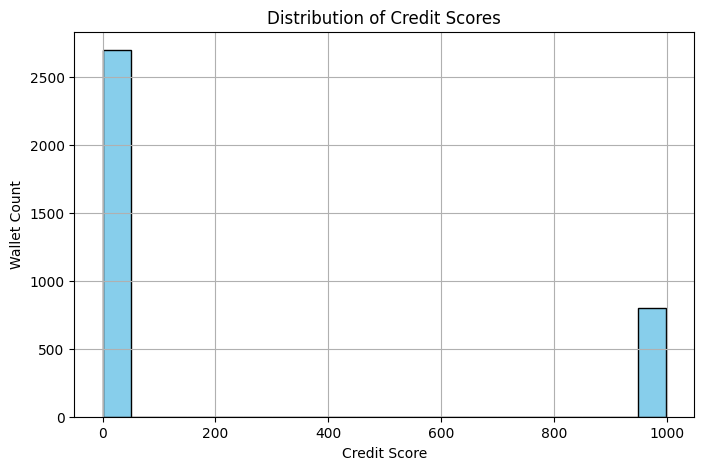

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/wallet_scores.csv")
plt.figure(figsize=(8,5))
df['credit_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()

In [11]:
# src/train_model.py

import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load features
df = pd.read_csv("data/wallet_features.csv")

# Continuous target: repayment ratio
df['repay_ratio'] = df['total_repay'] / (df['total_borrow'] + 1e-6)
df['repay_ratio'] = df['repay_ratio'].clip(0, 1)

# Features
features = ['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']
X = np.log1p(df[features])
y = df['repay_ratio']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LightGBM Regressor
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n📈 R² Score:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Save model
joblib.dump(model, "data/credit_model.pkl")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 2447, number of used features: 5
[LightGBM] [Info] Start training from score 0.259206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

['data/credit_model.pkl']

In [15]:
# src/scoring.py

import pandas as pd
import numpy as np
import joblib

# Load model and features
model = joblib.load("data/credit_model.pkl")
features = pd.read_csv("data/wallet_features.csv")

X = np.log1p(features[['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']])

# Predict continuous repay score
repay_score = model.predict(X)
repay_score = np.clip(repay_score, 0, 1)

# Convert to credit score (0–1000)
features['wallet'] = features['wallet']  # make sure it's present
features['credit_score'] = (repay_score * 1000).astype(int)

# Save output
features[['wallet', 'credit_score']].to_csv("data/wallet_scores.csv", index=False)



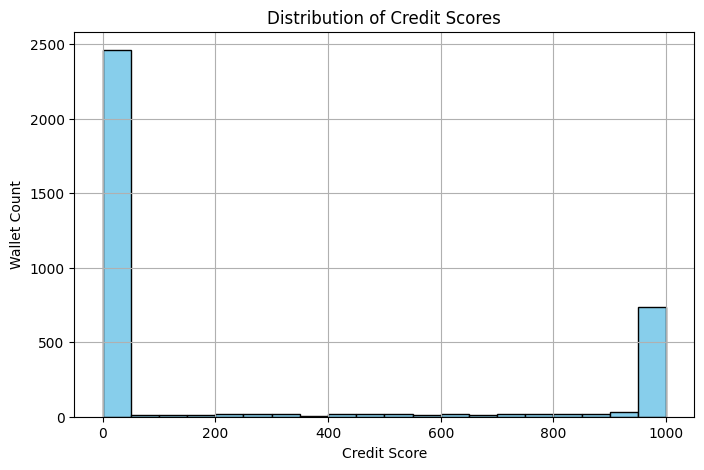

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/wallet_scores.csv")
plt.figure(figsize=(8,5))
df['credit_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [17]:
features = pd.read_csv("data/wallet_features.csv")
scores = pd.read_csv("data/wallet_scores.csv")
df = features.merge(scores, on="wallet")

df['score_segment'] = pd.cut(df['credit_score'], bins=[0,300,700,1000], labels=['Low', 'Medium', 'High'])

grouped = df.groupby('score_segment')[
    ['total_deposit', 'total_borrow', 'total_repay', 'total_liquidation', 'repay_borrow_ratio', 'tx_count']
].mean().round(2)

print(grouped)


               total_deposit  total_borrow   total_repay  total_liquidation  \
score_segment                                                                 
Low             2.145135e+16  1.021386e+15  3.577721e+13                0.0   
Medium          5.655467e+16  4.067026e+16  1.744045e+16                0.0   
High            3.860408e+16  8.555545e+15  9.482800e+15                0.0   

               repay_borrow_ratio  tx_count  
score_segment                                
Low                  7.000000e-02     43.92  
Medium               5.000000e-01    110.18  
High                 1.951231e+09     52.45  


/tmp/ipython-input-17-4268516708.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('score_segment')[


In [18]:
pip install xgboost


In [19]:
# src/train_model.py

import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load wallet features
df = pd.read_csv("data/wallet_features.csv")

# Create continuous target: repay-to-borrow ratio
df['repay_ratio'] = df['total_repay'] / (df['total_borrow'] + 1e-6)
df['repay_ratio'] = df['repay_ratio'].clip(0, 1)

# Features to use for training
features = ['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']
X = np.log1p(df[features])  # log transform to reduce skew
y = df['repay_ratio']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n📊 XGBoost Regressor Evaluation:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Save model
joblib.dump(model, "data/credit_model.pkl")



📊 XGBoost Regressor Evaluation:
R² Score: 0.9999
RMSE: 0.0034


['data/credit_model.pkl']

In [20]:
# src/scoring.py

import pandas as pd
import numpy as np
import joblib

# Load model
model = joblib.load("data/credit_model.pkl")

# Load features
df = pd.read_csv("data/wallet_features.csv")
X = np.log1p(df[['total_deposit', 'total_borrow', 'total_repay', 'repay_borrow_ratio', 'tx_count']])

# Predict continuous repayment reliability score
repay_score = model.predict(X)
repay_score = np.clip(repay_score, 0, 1)  # Ensure in [0, 1]

# Convert to credit score (0–1000)
df['credit_score'] = (repay_score * 1000).astype(int)

# Save results
df[['wallet', 'credit_score']].to_csv("data/wallet_scores.csv", index=False)
print("✅ Saved wallet_scores.csv")


✅ Saved wallet_scores.csv


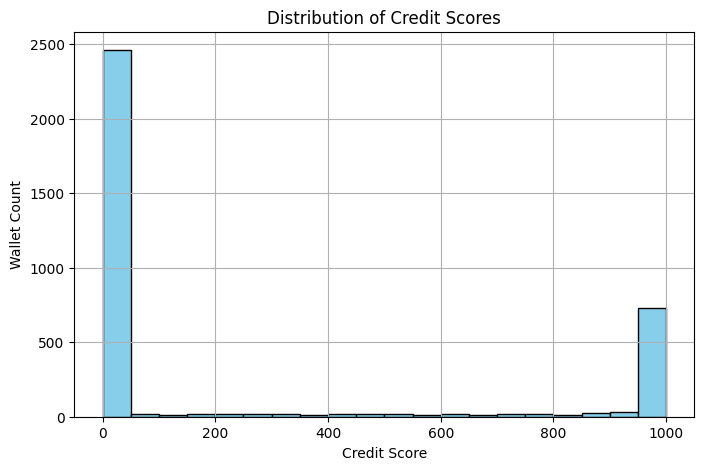

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/wallet_scores.csv")
plt.figure(figsize=(8,5))
df['credit_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [22]:
features = pd.read_csv("data/wallet_features.csv")
scores = pd.read_csv("data/wallet_scores.csv")
df = features.merge(scores, on="wallet")

df['score_segment'] = pd.cut(df['credit_score'], bins=[0,300,700,1000], labels=['Low', 'Medium', 'High'])

grouped = df.groupby('score_segment')[
    ['total_deposit', 'total_borrow', 'total_repay', 'total_liquidation', 'repay_borrow_ratio', 'tx_count']
].mean().round(2)

print(grouped)

               total_deposit  total_borrow   total_repay  total_liquidation  \
score_segment                                                                 
Low             3.384765e+16  1.943611e+15  7.065040e+13                0.0   
Medium          5.861777e+16  4.169393e+16  1.781646e+16                0.0   
High            3.851103e+16  8.554504e+15  9.491376e+15                0.0   

               repay_borrow_ratio  tx_count  
score_segment                                
Low                  1.400000e-01     61.40  
Medium               5.100000e-01    114.49  
High                 1.951231e+09     52.19  
